<a href="https://colab.research.google.com/github/SongheeJo/aiffelthon/blob/main/Baseline_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Load data**
    1. sampling rate 지정
        
        respireNet에서는 4kHz로 down sampling

    2. librosa.load 사용
    
    load 시 sampling rate 파라미터로 전체 data에 일괄 적용 가능

2. **Pre-processing**
    1. better SNR
        - `tfio.experimental.audio.trim()` tensorflow-io 패키지 노이즈 제거 ⇒ 들어보기
        - split & pad
            - 7초?
            - padding
              tfio.experimental.audio.fade tensorflow-io 패키지 페이딩 기술 ⇒ 현재 data에도 유용할까?
        - butterworth filter
            - `scipy.signal.butter()`

3. **Train_val_test_split**
    1. data imbalance 해결을 위해 파라미터 stratify 조정

4. **Augmentation**
    1. 일단 없이 진행 후 결과 보기
    2. 구현된 기본적인 augmentation 방법 적용해보고 결과 보기
        - 각 방법 별로 얼마나 결과가 좋아졌는지 저장 해둘 것
        - 각각 했을 때 vs 몇 개 같이 했을 때 결과 비교


5. **Feature Extraction**

6. **Build model**
   - transfer learning

7. **Evaluate**
    1. classification report text file 로 저장하는 module 생성
    2. recall 값과 f1 값

# 0. 추가사항


nlparg - speed variation (disease classification)

## 1. Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import soundfile as sf
import librosa as lb
import os

#root = '/content/drive/MyDrive/aiffel/aiffelthon/'
root = '/content/drive/MyDrive/'

###Data analysis (Disease)
crack & wheeze는 나중에


In [ ]:
diagnosis=pd.read_csv(root + 'Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
# df=pd.read_csv(root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t', names = ['start', 'end', 'crackles', 'weezels'])
# df.head()

In [ ]:
# path=root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
path=root + 'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

KeyboardInterrupt: ignored

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

NameError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    6898 non-null   int64  
 1   start         6898 non-null   float64
 2   end           6898 non-null   float64
 3   pid           6898 non-null   int64  
 4   mode          6898 non-null   object 
 5   filename      6898 non-null   object 
 6   disease       6898 non-null   object 
 7   crack_wheeze  6898 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 431.2+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 3
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


두 데이터프레임을 merge하기 위해 같은 타입으로 통일해줍니다

In [ ]:
df.pid=df.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

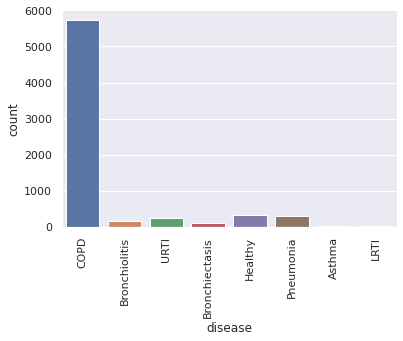

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(df.disease)
plt.xticks(rotation=90)

In [3]:
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

NameError: ignored

In [ ]:
data.to_csv('/content/drive/MyDrive/csv_data/data.csv',index=False)

##2. Pre-processing


###Divide Data
데이터 자르면서 crack_wheeze가 포함된 새로운 컬럼을 만듭니다.

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    '''

    max_ind = len(raw_data) #원본 데이터
    start_ind = min(int(start * sr), max_ind) #시작 시간 x sample rate
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
i,c=0,0

filename2 = []
start2 = []
end2 = []
pid2 = []
mode2 = []
disease2 = []
crack_wheeze = []
for index,row in data.iterrows(): #enumerte 과 비슷
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    audio_file_loc=path + filename + '.wav' #wav 파일 경로 저장
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav' #새로운 파일 이름

    filename2.append(filename)
    start2.append(row['start'])
    end2.append(row['end'])
    pid2.append(row['pid'])
    mode2.append(row['mode'])
    disease2.append(row['disease'])

    if row['crackles'] == 0 and row['weezels'] == 0:
      crack_wheeze.append(0)
    elif row['crackles'] == 1 and row['weezels'] == 0:
      crack_wheeze.append(1)
    elif row['crackles'] == 0 and row['weezels'] == 1:
      crack_wheeze.append(2)
    else:
      crack_wheeze.append(3)
    
    save_path='/content/drive/MyDrive/processed_audio_files_8/' + filename
    c+=1 #파일 개수 세기
    
    audioArr,sampleRate=lb.load(audio_file_loc, sr = 16000)
    pureSample=getPureSample(audioArr,start,end,sampleRate) #잘린 데이터 return, 길이는 상관 없음

    if c % 100 == 0:
      print(c)
    
    
    sf.write(file=save_path,data=pureSample,samplerate=sampleRate)
print('Total Files Processed: ',c)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
Total Files Processed:  6898


In [ ]:
processed = pd.DataFrame(columns=['start','end','pid','mode','filename','disease','crack_wheeze'])
processed['start'] = start2
processed['end'] = end2
processed['pid'] = pid2
processed['mode'] = mode2
processed['filename'] = filename2
processed['disease'] = disease2
processed['crack_wheeze'] = crack_wheeze

processed.to_csv(root + 'processed.csv')

In [4]:
processed = pd.read_csv(root + 'processed.csv') #우리가 계속 쓸 컬럼입니다

In [ ]:
processed

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...,...
6893,6893,12.007,13.707,159,sc,159_1b1_Ll_sc_Meditron_7.wav,Healthy,0
6894,6894,13.707,15.550,159,sc,159_1b1_Ll_sc_Meditron_8.wav,Healthy,0
6895,6895,15.550,17.336,159,sc,159_1b1_Ll_sc_Meditron_9.wav,Healthy,0
6896,6896,17.336,18.841,159,sc,159_1b1_Ll_sc_Meditron_10.wav,Healthy,0


원하는 길이로 패딩해서 wav로 저장합니다

In [ ]:
sr=16000

def zero_padding(pureSample, reqLen = 7 * sr):
  padded = lb.util.pad_center(pureSample, reqLen)
  return padded

In [ ]:
for index,row in processed.iterrows():
  maxLen=7 #5,6,7 선택
  start=row['start']
  end=row['end']
  filename=row['filename']
    
  audio_file_loc= root + 'processed_audio_files/' + filename #5,6,7 선택
  processed_sample, _ = lb.load(audio_file_loc, sr = sr) #자르고 전처리한 데이터

  #If len > maxLen , change it to maxLen
  if end-start>maxLen:
      end=start+maxLen
      processed_sample = processed_sample[int(start * sr) : int(end * sr)] #초에 맞춰주기
  
  padded_data = zero_padding(processed_sample,7 * sr)
  
  save_path = root + 'processed_audio_files_7sec_22050/' + filename

  sf.write(file=save_path,data=padded_data,samplerate = sr)


###butter worth filter()

##3. Train_val_test_split

In [10]:
from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split( #disease 분류
    processed,processed.disease,stratify=processed.disease,random_state=42,test_size=0.2)

Xtrain_1,Xval_1,ytrain_1,yval_1=train_test_split( #crack_wheeze 분류
    processed,processed.crack_wheeze,stratify=processed.crack_wheeze,random_state=42,test_size=0.2)

In [64]:
Xtrain

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
2330,2330,18.2320,19.9580,203,mc,203_1p3_Pr_mc_AKGC417L_9.wav,COPD,1
2304,2304,5.9820,7.9820,203,mc,203_1p3_Pl_mc_AKGC417L_3.wav,COPD,1
5696,5696,9.7640,11.7070,140,mc,140_2b3_Ll_mc_LittC2SE_4.wav,Pneumonia,0
5364,5364,7.0070,9.1500,135,mc,135_2b3_Ar_mc_LittC2SE_3.wav,Pneumonia,0
1790,1790,16.4470,18.1190,193,mc,193_1b2_Ll_mc_AKGC417L_10.wav,COPD,0
...,...,...,...,...,...,...,...,...
1217,1217,17.3870,19.4940,178,mc,178_1b2_Ar_mc_AKGC417L_11.wav,COPD,1
1473,1473,7.1055,9.0497,185,sc,185_1b1_Lr_sc_Litt3200_2.wav,COPD,0
3405,3405,5.2883,9.5592,222,sc,222_1b1_Pr_sc_Meditron_1.wav,COPD,0
2069,2069,2.2930,5.4400,198,mc,198_1b5_Tc_mc_AKGC417L_1.wav,COPD,2


In [ ]:
len(Xtrain)

5518

In [ ]:
ytrain

2330         COPD
2304         COPD
5696    Pneumonia
5364    Pneumonia
1790         COPD
          ...    
1217         COPD
1473         COPD
3405         COPD
2069         COPD
1393         COPD
Name: disease, Length: 5518, dtype: object

In [ ]:
yval

2120             COPD
4222             LRTI
2018          Healthy
4364             COPD
2509             COPD
            ...      
320     Bronchiolitis
2950             URTI
3179             COPD
1115             COPD
5749             COPD
Name: disease, Length: 1380, dtype: object

In [ ]:
Xtrain_1

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
2103,2103,1.243,4.049,198,mc,198_6p1_Lr_mc_AKGC417L_1.wav,COPD,1
6340,6340,11.580,14.072,154,mc,154_2b4_Lr_mc_AKGC417L_4.wav,COPD,1
4914,4914,14.249,17.702,130,mc,130_3b3_Ll_mc_AKGC417L_4.wav,COPD,1
3596,3596,0.887,2.601,107,mc,107_2b3_Lr_mc_AKGC417L_0.wav,COPD,0
6739,6739,15.918,17.972,158,mc,158_1p4_Pr_mc_AKGC417L_7.wav,COPD,3
...,...,...,...,...,...,...,...,...
6075,6075,16.185,18.756,151,mc,151_2p4_Al_mc_AKGC417L_5.wav,COPD,0
6417,6417,10.444,12.423,154,mc,154_4b4_Pl_mc_AKGC417L_5.wav,COPD,0
6697,6697,2.212,5.050,158,mc,158_1p3_Pl_mc_AKGC417L_1.wav,COPD,2
1438,1438,13.607,18.836,181,mc,181_1b3_Tc_mc_LittC2SE_3.wav,COPD,0


disease 비율

In [ ]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832910
Healthy           0.046756
Pneumonia         0.041319
URTI              0.035158
Bronchiolitis     0.023197
Bronchiectasis    0.015042
LRTI              0.004712
Asthma            0.000906
Name: disease, dtype: float64

crackle & wheeze 비율

In [ ]:
Xtrain_1.crack_wheeze.value_counts()/Xtrain_1.shape[0]

0    0.527909
1    0.270207
2    0.128489
3    0.073396
Name: crack_wheeze, dtype: float64

In [ ]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')

label 인코딩
- disease 라벨에만 적용 시킵니다
- crackle & wheeze 라벨은 이미 int로 되어있습니다

In [66]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [67]:
ytrain

array([3, 3, 6, ..., 3, 3, 3])

##4. Augmentation(추후 추가)


## nlpaug의 Audio Augmenter

In [6]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 8.3 MB/s 


In [7]:
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer

In [8]:
def getSounds(path):
    soundArr,sr=lb.load(path)
    return soundArr

In [11]:
root_path= root + 'processed_audio_files_7sec_22050/'
Xtrain_a=[]
for idx,row in Xtrain.iterrows():
    path=root_path + row['filename']
    c=getSounds(path)
    Xtrain_a.append(c)

Xtrain_array=np.array(Xtrain_a)

In [12]:
Xtrain_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
len(Xtrain_array)

5518

In [14]:
Xtrain_array.shape

(5518, 154350)

In [15]:
np.save(root + 'Xtrain_7sec.npy', Xtrain_array)

In [16]:
Xtrain_array = np.load('/content/drive/MyDrive/Xtrain_7sec.npy')

In [17]:
# ytrain_array=ytrain.values

### speed variation

In [18]:
# speed variation
aug_1 = naa.speed.SpeedAug(zone=(0.2, 0.8), coverage=1.0, factor=(0.5, 2), name='Speed_Aug', verbose=0, stateless=True) # coverage 개념이 와닿지 않음 - 1과 0, 0.5 비교해보고 zone과 coverage관계 살피기

augmented_data_speed_variation = []
type(augmented_data_speed_variation)

list

In [19]:
type(Xtrain_array[0])

numpy.ndarray

In [20]:
aug_1.augment(Xtrain_array[0])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [21]:
type(aug_1.augment(Xtrain_array[0]))

numpy.ndarray

In [22]:
len(aug_1.augment(Xtrain_array[0]))

133948

In [23]:
augmented_data_speed_variation = []
for i in range(len(Xtrain_array)): # 훈련 데이터 입력 
    x = aug_1.augment(Xtrain_array[i])
    augmented_data_speed_variation.append(x)
    i += 1

In [24]:
print(augmented_data_speed_variation)

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=fl

In [25]:
len(augmented_data_speed_variation)

5518

In [26]:
np.save(root + 'Xtrain_7sec_augmented_data_speed_variation.npy',augmented_data_speed_variation)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
augmented_data_speed_variation = np.load('/content/drive/MyDrive/Xtrain_7sec_augmented_data_speed_variation.npy', allow_pickle=True)

In [28]:
Xtrain_array = augmented_data_speed_variation

### Random shifting

In [29]:
'''
# random shifting
aug_2 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='random', shift_direction='random', name='Shift_Aug', verbose=0, stateless=True) # direction과 shift_direction의 차이 찍어보기
augmented_data_random_shifting = aug_2.augment(Xtrain_2)
'''

"\n# random shifting\naug_2 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='random', shift_direction='random', name='Shift_Aug', verbose=0, stateless=True) # direction과 shift_direction의 차이 찍어보기\naugmented_data_random_shifting = aug_2.augment(Xtrain_2)\n"

In [30]:
'''
# random shifting (direction left)
aug_2_2 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='left', shift_direction='random', name='Shift_Aug_2', verbose=0, stateless=True)
augmented_data = aug_2_2.augment(Xtrain_2)
'''

"\n# random shifting (direction left)\naug_2_2 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='left', shift_direction='random', name='Shift_Aug_2', verbose=0, stateless=True)\naugmented_data = aug_2_2.augment(Xtrain_2)\n"

In [31]:
'''
# random shifting (direction right)
aug_2_3 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='right', shift_direction='random', name='Shift_Aug_3', verbose=0, stateless=True)
augmented_data = aug_2_3.augment(Xtrain_2)
'''

"\n# random shifting (direction right)\naug_2_3 = naa.shift.ShiftAug(re_sampleRate, duration=3, direction='right', shift_direction='random', name='Shift_Aug_3', verbose=0, stateless=True)\naugmented_data = aug_2_3.augment(Xtrain_2)\n"

### pitch

In [32]:
'''
# pitch
aug_3 = naa.pitch.PitchAug(re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, factor=(-10, 10), name='Pitch_Aug', verbose=0, stateless=True) 
augmented_data = aug_3.augment(Xtrain_2)
'''

"\n# pitch\naug_3 = naa.pitch.PitchAug(re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, factor=(-10, 10), name='Pitch_Aug', verbose=0, stateless=True) \naugmented_data = aug_3.augment(Xtrain_2)\n"

In [33]:
'''
# pitch (duration-provided)
aug_3_2 = naa.pitch.PitchAug(re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, factor=(-10, 10), name='Pitch_Aug', verbose=0, stateless=True) # 찍어보고 duration과 coverage와의 관계 이해
augmented_data = aug_3.augment(Xtrain_2)
'''

"\n# pitch (duration-provided)\naug_3_2 = naa.pitch.PitchAug(re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, factor=(-10, 10), name='Pitch_Aug', verbose=0, stateless=True) # 찍어보고 duration과 coverage와의 관계 이해\naugmented_data = aug_3.augment(Xtrain_2)\n"

### mask

In [34]:
'''
# mask
aug_4 = naa.mask.MaskAug(sampling_rate=re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, mask_with_noise=True, name='Mask_Aug', verbose=0, stateless=True) 
augmented_data = aug_4_2.augment(Xtrain_2)
'''

"\n# mask\naug_4 = naa.mask.MaskAug(sampling_rate=re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, mask_with_noise=True, name='Mask_Aug', verbose=0, stateless=True) \naugmented_data = aug_4_2.augment(Xtrain_2)\n"

In [35]:
'''
# mask (noise False)
aug_4_2 = naa.mask.MaskAug(sampling_rate=re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, mask_with_noise=True, name='Mask_Aug', verbose=0, stateless=True) # mask with noise Ture/False
augmented_data = aug_4_3.augment(Xtrain_2)
'''

"\n# mask (noise False)\naug_4_2 = naa.mask.MaskAug(sampling_rate=re_sampleRate, zone=(0.2, 0.8), coverage=1.0, duration=None, mask_with_noise=True, name='Mask_Aug', verbose=0, stateless=True) # mask with noise Ture/False\naugmented_data = aug_4_3.augment(Xtrain_2)\n"

In [36]:
'''
# mask normalization?
aug = naa.NormalizeAug(method='standard', zone=(0.2, 0.8), coverage=0.3, name='Normalize_Aug', verbose=0, stateless=True) # standard normalization
augmented_data = aug.augment(data)
'''

"\n# mask normalization?\naug = naa.NormalizeAug(method='standard', zone=(0.2, 0.8), coverage=0.3, name='Normalize_Aug', verbose=0, stateless=True) # standard normalization\naugmented_data = aug.augment(data)\n"

In [37]:
'''
# weighted random sampler to sample mini-batches uniformly from each class 
# 형태님께서 말씀해주셨던 논문?

# Randomly weighted CNNs for (music) audio classification 
# Randomly weighted CNNs for (music) audio classification github
'''

'''
#찍어보자!

librosa_display.waveplot(df, sr=re_sampleRate, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=re_sampleRate, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

'''

"\n#찍어보자!\n\nlibrosa_display.waveplot(df, sr=re_sampleRate, alpha=0.5)\nlibrosa_display.waveplot(augmented_data, sr=re_sampleRate, color='r', alpha=0.25)\n\nplt.tight_layout()\nplt.show()\n\n"

## Numpy, Librosa

In [38]:
# Changing Speed
# def manipulate(data, speed_factor):
#     return librosa.effects.time_stretch(data, speed_factor)

## CV 기법

In [39]:
# audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

In [40]:
# print(audio)

In [41]:
'''
# masking
!pip install tensorflow-io[tensorflow] # 이 버전에 맞는 텐서플로-io 설치
import tensorflow as tf 
import tensorflow_io as tfio
audio = tfio.audio.AudioIOTensor(data_preprocessed, dtype=None)

print(audio)
'''

'\n# masking\n!pip install tensorflow-io[tensorflow] # 이 버전에 맞는 텐서플로-io 설치\nimport tensorflow as tf \nimport tensorflow_io as tfio\naudio = tfio.audio.AudioIOTensor(data_preprocessed, dtype=None)\n\nprint(audio)\n'

In [42]:
# mixup


# blur

##5. Feature Extraction

- Mel spectrogram

In [43]:
def getFeatures(path):
    soundArr,sr=lb.load(path)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sr) #sr=16000
    return mSpec

**default 값**

sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', power=2.0,

In [44]:
root_path= root + 'processed_audio_files_7sec_22050/'
mSpec_v=[]
for idx,row in Xval.iterrows():
    path=root_path + row['filename']
    c=getFeatures(path)
    mSpec_v.append(c)

mSpec_val=np.array(mSpec_v)

In [45]:
mSpec_val.shape

(1380, 128, 302)

In [46]:
root_path= root + 'processed_audio_files_7sec_22050/'
mSpec_t=[]
for idx,row in Xtrain.iterrows():
    path=root_path + row['filename']
    c=getFeatures(path)
    mSpec_t.append(c)

mSpec_train=np.array(mSpec_t)

In [47]:
np.save(root + 'Mel_spectrogram_train_7sec_augmented_data_speed_variation_2.npy',mSpec_train)
np.save(root + 'Mel_spectrogram_val_7sec_augmented_data_speed_variation_2.npy',mSpec_val)

In [48]:
mSpec_train = np.load(root + 'Mel_spectrogram_train_7sec_augmented_data_speed_variation_2.npy')
mSpec_val = np.load(root + 'Mel_spectrogram_val_7sec_augmented_data_speed_variation_2.npy')

In [49]:
len(mSpec_train)

5518

In [50]:
len(mSpec_val)

1380

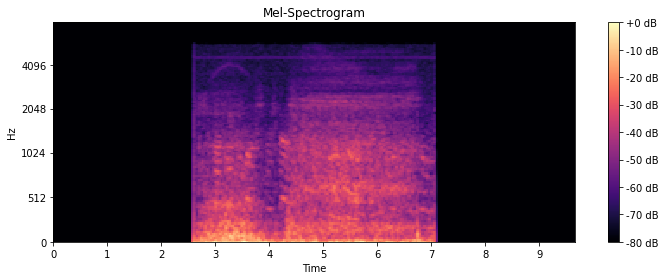

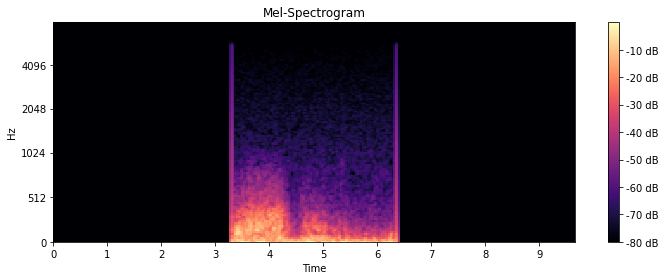

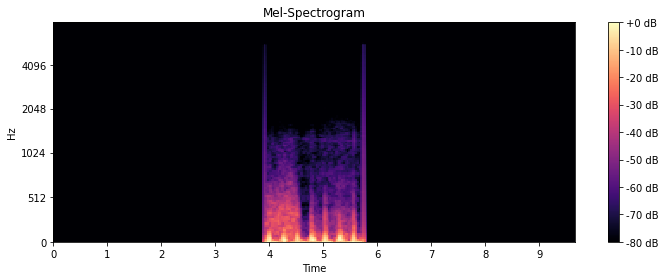

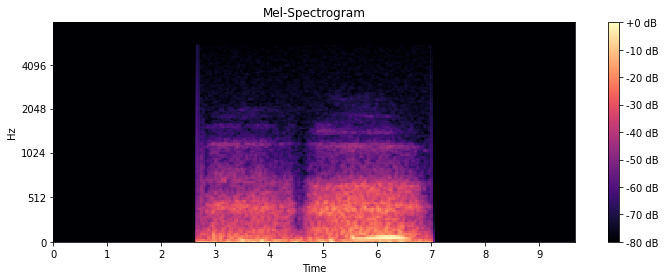

In [51]:
sr=16000
randFiles = [10 * x for x in range(1,5)]

for i,audioFile in enumerate(randFiles):
  
  plt.figure(figsize=(10, 4))
  plt.title('Mel-Spectrogram') 
  librosa.display.specshow(
      librosa.power_to_db(mSpec_train[audioFile], ref=np.max), y_axis='mel', sr=sr, hop_length=512, x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  
  plt.tight_layout()
  plt.savefig('mSec_nlpaug_speed_variation_2_disease.png')
  plt.show()

##6. Build model

- Depthwise Convolution
- ResNet
- Efficient Net

disese model

In [52]:
mSpec_input=keras.layers.Input(shape=(128,302,1),name="mSpecInput")

x = keras.layers.Conv2D(
                filters=32,
                kernel_size=5,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(mSpec_input)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(1,2),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=96,
                kernel_size=2,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=128,
                kernel_size=2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(8,activation='softmax')(x)

mSpec_model=keras.Model(mSpec_input, output, name="mSpecModel")

In [53]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 302, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 101, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 4, 96)          2

crack & wheeze model

In [54]:
mSpec_input=keras.layers.Input(shape=(128,302,1),name="mSpecInput")

x = keras.layers.Conv2D(
                filters=32,
                kernel_size=5,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(mSpec_input)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(1,2),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=96,
                kernel_size=2,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=128,
                kernel_size=2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(4,activation='softmax')(x) #class 변화 주의

mSpec_model_cw=keras.Model(mSpec_input, output, name="mSpecModel_cw")

In [55]:
mSpec_model_cw.summary()

Model: "mSpecModel_cw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 302, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 101, 32)       832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 25, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 4, 96)        

###training(disease)

In [56]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [57]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/checkpoint-only-zero-7sec-001.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [58]:
len(mSpec_train)

5518

In [59]:
len(ytrain)

5518

In [60]:
len(mSpec_val)

1380

In [61]:
len(yval)

1380

In [65]:
ytrain

2330         COPD
2304         COPD
5696    Pneumonia
5364    Pneumonia
1790         COPD
          ...    
1217         COPD
1473         COPD
3405         COPD
2069         COPD
1393         COPD
Name: disease, Length: 5518, dtype: object

In [68]:
history=mSpec_model.fit(
    mSpec_train, # fit 할 때 ndarray > tensor로 바꾸는 느낌?
    ytrain,
    validation_data=(mSpec_val,yval),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
173/173 [==============================] - 16s 22ms/step - loss: 28.0054 - sparse_categorical_accuracy: 0.6888 - val_loss: 2.6573 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 2/100
173/173 [==============================] - 2s 13ms/step - loss: 3.7765 - sparse_categorical_accuracy: 0.7423 - val_loss: 1.2329 - val_sparse_categorical_accuracy: 0.8196 - lr: 0.0010
Epoch 3/100
173/173 [==============================] - 2s 12ms/step - loss: 2.3382 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.9336 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 1.4553 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
173/173 [==============================] - 2s 12ms/step - loss: 1.0924 - sparse_categorical_accuracy: 0.8012 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
173/173 [==

In [69]:
y_pred = mSpec_model.predict(mSpec_val)

###training(crackle & wheeze)

In [70]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model_cw.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model_cw.optimizer.learning_rate, 0.001)

In [71]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/checkpoint-only-zero-7sec-cw-001.h5'
my_callbacks_1 = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [72]:
len(mSpec_val)

1380

In [73]:
len(yval_1)

1380

In [74]:
history=mSpec_model_cw.fit(
    mSpec_train, # fit 할 때 ndarray > tensor로 바꾸는 느낌?
    ytrain_1,
    validation_data=(mSpec_val,yval_1),
    epochs=100,verbose=1,
    callbacks=my_callbacks_1
)

Epoch 1/100
173/173 [==============================] - 4s 15ms/step - loss: 36.1580 - sparse_categorical_accuracy: 0.3516 - val_loss: 2.0243 - val_sparse_categorical_accuracy: 0.4812 - lr: 0.0010
Epoch 2/100
173/173 [==============================] - 2s 12ms/step - loss: 2.9325 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.2213 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 3/100
173/173 [==============================] - 2s 12ms/step - loss: 1.4506 - sparse_categorical_accuracy: 0.5145 - val_loss: 1.1633 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 1.3288 - sparse_categorical_accuracy: 0.5228 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 5/100
173/173 [==============================] - 2s 12ms/step - loss: 1.3376 - sparse_categorical_accuracy: 0.5217 - val_loss: 1.1468 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 6/100
173/173 [===

In [75]:
y_pred_1 = mSpec_model_cw.predict(mSpec_val)

##7. Evaluate
disease

In [76]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(np.argmax(y_pred, axis = 1), yval)

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   1,   21,   32, 1150,   64,    6,   57,   49],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [77]:
from sklearn.metrics import classification_report

In [78]:
target_names=['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis', 'Pheumonia', 'Bronchiolitis']

with open( root+ "clf_report_zero_7sec.txt", "w") as text_file:
    print(classification_report(yval, np.argmax(y_pred, axis = 1), target_names=target_names), file=text_file)

print(classification_report(yval, np.argmax(y_pred, axis = 1), target_names=target_names))

                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00         1
       Healthy       0.00      0.00      0.00        21
        Asthma       0.00      0.00      0.00        32
          COPD       0.83      1.00      0.91      1150
          LRTI       0.00      0.00      0.00        64
Bronchiectasis       0.00      0.00      0.00         6
     Pheumonia       0.00      0.00      0.00        57
 Bronchiolitis       0.00      0.00      0.00        49

      accuracy                           0.83      1380
     macro avg       0.10      0.12      0.11      1380
  weighted avg       0.69      0.83      0.76      1380



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

crackle & wheeze

In [79]:
confusion_matrix(np.argmax(y_pred_1, axis = 1), yval_1)

array([[729, 373, 177, 101],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

In [80]:
'''
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Flower Category')
ax.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])
ax.yaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])

## Display the visualization of the Confusion Matrix.
plt.show()
'''

"\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')\n\nax.set_title('Seaborn Confusion Matrix with labels\n\n');\nax.set_xlabel('\nPredicted Flower Category')\nax.set_ylabel('Actual Flower Category ');\n\n## Ticket labels - List must be in alphabetical order\nax.xaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])\nax.yaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])\n\n## Display the visualization of the Confusion Matrix.\nplt.show()\n"

In [81]:
target_names=['Normal', 'crackle', 'wheeze', 'both']

with open( root+ "clf_report_zero_7sec_cw.txt", "w") as text_file:
    print(classification_report(yval_1, np.argmax(y_pred_1, axis = 1), target_names=target_names), file=text_file)

print(classification_report(yval_1, np.argmax(y_pred_1, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.53      1.00      0.69       729
     crackle       0.00      0.00      0.00       373
      wheeze       0.00      0.00      0.00       177
        both       0.00      0.00      0.00       101

    accuracy                           0.53      1380
   macro avg       0.13      0.25      0.17      1380
weighted avg       0.28      0.53      0.37      1380



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat